# Assumption Mining for Monotone Systems

The code used to generate the figures for the paper _Directed Specifications and Assumption Mining for Monotone Dynamical Systems_, to appear at HSCC 2016.

#### Runtime Requirements
In addition to python 2.7 and ipython, you'll need the following:
- Timing profiler magic commands. Installation instructions found [here](http://pynash.org/2013/03/06/timing-and-profiling/)
- The [z3 theorem prover](https://github.com/Z3Prover/z3/wiki) with python API. On Mac OSX with [homebrew](http://brew.sh/), you can install it by running `brew install z3` in the terminal.

This notebook was generated on an early-2013 Retina Macbook Pro with 8GB of RAM and an 2.4GHz Intel Core i7 processor with python 2.7.11 and ipython notebook server 4.0.6.

In [1]:
%pylab
%matplotlib inline

import os

import numpy as np

import AGmining as AG 
from stl import G, F, STL
from trafficCTM import actm

epsilon_update = {}

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


# Mine Assumption Set until $\epsilon$ = .25

The miner terminates as soon as it reaches $\epsilon$ = .25, instead of mining for a fixed number of samples. Therefore, it's only useful for the timing plot (Fig. 12) and the lower plot in Fig. 11. It's not useful for the upper plot because that plot requires a fixed number of samples.

In [2]:
# Set parameters
sig_lengths = range(2,12, 1);       # Length of disturbance signal
stopping_eps = .25                  # Desired grid granularity (smaller = finer grid)
alpha = .95                         # Learning rate 
verbose = True                      # print profiler timing as you go

num_tested_lengths = len(sig_lengths)

# Initialize metrics
total_points = np.zeros((num_tested_lengths))
total_time = np.zeros((num_tested_lengths))
solver_time = np.zeros((num_tested_lengths))
precision = np.zeros((num_tested_lengths))
eps_hist = np.zeros((num_tested_lengths), dtype = numpy.ndarray)

for i in range(len(sig_lengths)):
    T = sig_lengths[i]
    if verbose:
        print "\nSignal length: ", T
    net = actm()
    lb = np.zeros([T])
    ub = 1.0 * np.ones([T])

    # Generate STL Specification
    congestion = STL(pred_eval = net.congestion_signal) # generates predicate
    occasional_congestion = G(F(congestion, a = 0, b = 1)) 
    spec = lambda x: occasional_congestion(x)[0] 

    # Mine Assumption Set
    mine_init_states = True
    a_miner = AG.assumption_miner(system = net, checkspec = spec, mine_init_states = mine_init_states,\
                        T = T, epsilon = .6, epsilon_final = stopping_eps * alpha, max_num_points = 7000,\
                        lower_bound = net.input_lower, upper_bound = net.input_upper, \
                        learningrate = alpha, binary_search = False, 
                        disturb_over_init_state = net.input_upper[0])

    # Extract Timing Profile
    %lprun -T temp.txt -s -m AGmining a_miner.mine()
    filename = "profile_%s_%s.txt" % (a_miner.max_num_points, a_miner.learningrate)
    os.rename("temp.txt", filename)
    f=open(filename)
    lines=f.readlines()
    f.close()
    
    # Double Check Miner Results
    assert (a_miner.check_miner()), "Assumption miner failed check"
    
    total_points[i] = a_miner.lower_points.shape[0] + a_miner.upper_points.shape[0]
    precision[i] = a_miner.prev_epsilon
    eps_hist[i] = np.array(a_miner.epsilon_history)
    
    mine_time_line = ([line for line in lines if 'Function: mine' in line])[0]
    mine_time_index = lines.index(mine_time_line) - 2
    total_time[i] = float(lines[mine_time_index].split()[2])
    solver_time[i] = float(([line for line in lines if 'self.solver.check' in line][0]).split()[2]) / 10.0**3
    
    if verbose:
        print "Total time in s: ", total_time[i] # total time in s
        print "Solver time in ms: ", solver_time[i] # solver time in ms
        print "Certified Precision: ", precision[i]
        print "Current Precision: ", a_miner.epsilon
        print "Total points: ", total_points[i], "\n"
    


Signal length:  2
Points:  0 , epsilon:  0.6
Miner terminated

*** Profile printout saved to text file u'temp.txt'. 
Total time in s:  7.59804
Solver time in ms:  922.392
Certified Precision:  0.238328591075
Current Precision:  0.226412161521
Total points:  497.0 


Signal length:  3
Points:  0 , epsilon:  0.6
Points:  500 , epsilon:  0.238328591075
Miner terminated

*** Profile printout saved to text file u'temp.txt'. 
Total time in s:  11.085
Solver time in ms:  1422.078
Certified Precision:  0.238328591075
Current Precision:  0.226412161521
Total points:  601.0 


Signal length:  4
Points:  0 , epsilon:  0.6
Points:  500 , epsilon:  0.398052258773
Miner terminated

*** Profile printout saved to text file u'temp.txt'. 
Total time in s:  18.5293
Solver time in ms:  1817.558
Certified Precision:  0.238328591075
Current Precision:  0.226412161521
Total points:  938.0 


Signal length:  5
Points:  0 , epsilon:  0.6
Points:  500 , epsilon:  0.398052258773
Points:  1000 , epsilon:  0.2383

### Print out various statistics

In [3]:
print "Signal length: ", np.array(sig_lengths)
print "Total points until desired precision: ", total_points
print "Total time(s): ", total_time
print "Total SMT solver time(ms): ", solver_time
print "Fraction of time spent in solver: ", solver_time*.001 / total_time

Signal length:  [ 2  3  4  5  6  7  8  9 10 11]
Total points until desired precision:  [  497.   601.   938.  1352.  4630.  5142.  7000.  7000.  7000.  7000.]
Total time(s):  [   7.59804   11.085     18.5293    31.6565   132.957    155.635    246.101
  276.595    275.173    280.191  ]
Total SMT solver time(ms):  [   922.392   1422.078   1817.558   3147.379  27255.004  25194.617
  51901.266  60311.444  38110.565  38366.942]
Fraction of time spent in solver:  [ 0.12139868  0.1282885   0.09809102  0.09942284  0.20499112  0.16188272
  0.21089417  0.21804965  0.13849675  0.13693139]


# Plot Miner Time until $\epsilon$ = .25

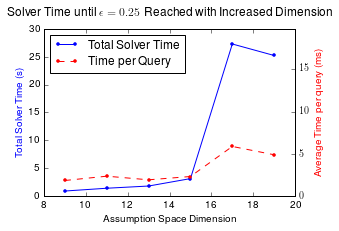

In [4]:
plot_until = 6

dimensions = np.array(sig_lengths[0:plot_until])*net.input_dim + net.state_dim

average_solver_time = solver_time / total_points

fig, ax1 = plt.subplots()
fig.set_size_inches(4.5, 3)

# Plot Total Solver Time
line1 = ax1.plot(dimensions, solver_time[0:plot_until] * .001, '.-', label = 'Precision')
plt.rc('text', usetex=True)
ax1.set_ylabel(r'Total Solver Time (s)', color = 'b')
ax1.set_xlabel("Assumption Space Dimension")
ax1.set_xlim([0, 30])
ax1.set_ylim([0,solver_time[0:plot_until].max() * .001 * 1.1])

# Plot Time per SMT Query on the same plot
ax2 = ax1.twinx()
ax2.set_ylabel(r'Average Time per query (ms)', color = 'r')
line2 = ax2.plot(dimensions, average_solver_time[0:plot_until], '.r--', label = 'Solver')
ax2.set_ylim([0,(solver_time / total_points).max() * 2.3])

plt.legend(line1 + line2,('Total Solver Time', 'Time per Query'), loc='upper left')
plt.title(r"Solver Time until ${\epsilon = %s}$ Reached with Increased Dimension" % (stopping_eps), y=1.05)
fig.set_size_inches(4.5, 3)
plt.show()

# Save figure
save_fig = False
if save_fig:
    fig.savefig('fig_solver_until_epsilon.pdf', bbox_inches='tight')
    np.savez('fig_solver_until_epsilon.npz', total_points = total_points, 
                             precision = precision, 
                             dimensions = dimensions, 
                             total_time = total_time, 
                             solver_time = solver_time,
                             eps_hist = eps_hist, 
                             stopping_eps = stopping_eps,
                             alpha = alpha
            )

## Plot Samples Required to Reach Fixed Precision

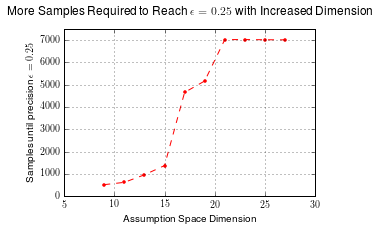

In [5]:
dimensions = np.array(sig_lengths)*net.input_dim + net.state_dim

# Determine the number of points required to attain a certain precision
def num_greater(x, epsilon):
    b = np.array(x)
    return b[b >= epsilon].shape[0]
num_iter_until_prec = np.array([num_greater(eps_hist[i], stopping_eps*alpha) for i in range(len(sig_lengths))])

fig2,ax2 = plt.subplots()
line2 = ax2.plot(dimensions, num_iter_until_prec, '.r--', label = 'Iterations')
ax2.set_ylim([0,7500])
ax2.set_xlabel("Assumption Space Dimension")
ax2.set_ylabel(r'Samples until precision ${\epsilon} = %s $' % (stopping_eps))
ax2.grid()
ax2.set_title(r"More Samples Required to Reach ${\Large \epsilon} = %s$ with Increased Dimension" % (stopping_eps), y=1.05)
fig2.set_size_inches(4.5, 3)
plt.show()

save_fig = False
if save_fig:
    fig2.savefig('fig_points_until_epsilon.pdf', bbox_inches='tight')
    np.savez('fig_points_until_epsilon.npz', total_points = total_points, 
                             precision = precision, 
                             dimensions = dimensions, 
                             total_time = total_time, 
                             solver_time = solver_time,
                             eps_hist = eps_hist, 
                             stopping_eps = stopping_eps,
                             alpha = alpha
            )


## Mine for 7000 Samples and Obtain Grid Granularity Reached

We mine for a fixed number of samples and observe the granularity of the grid by looking at the $\epsilon$-certificate.

In [6]:
# Set parameters
sig_lengths = range(2,12, 1); num_tested_lengths = len(sig_lengths)
stopping_eps = .001
alpha = .95
num_samples = 7000
verbose = True                      # print profiler timing as you go

# Initialize metrics
total_points = np.zeros((num_tested_lengths))
total_time = np.zeros((num_tested_lengths))
solver_time = np.zeros((num_tested_lengths))
precision = np.zeros((num_tested_lengths))
eps_hist = np.zeros((num_tested_lengths), dtype = numpy.ndarray)

for i in range(len(sig_lengths)):
    T = sig_lengths[i]
    print "\n Signal length: ", T
    net = actm()
    lb = np.zeros([T])
    ub = 1.0 * np.ones([T])

    congestion = STL(pred_eval = net.congestion_signal)
    occasional_congestion = G(F(congestion, a = 0, b = 1))
    spec = lambda x: occasional_congestion(x)[0]

    mine_init_states = True
    a_miner = AG.assumption_miner(system = net, checkspec = spec, mine_init_states = mine_init_states,\
                        T = T, epsilon = .6, epsilon_final = stopping_eps * alpha, max_num_points = num_samples,\
                        lower_bound = net.input_lower, upper_bound = net.input_upper, \
                        learningrate = alpha, binary_search = False, 
                        disturb_over_init_state = net.input_upper[0])

    time_miner = True
    if time_miner:
        # Extract Timing Profile
        %lprun -T temp.txt -s -m AGmining a_miner.mine()
        filename = "profile_%s_%s.txt" % (a_miner.max_num_points, a_miner.learningrate)
        os.rename("temp.txt", filename)
        f=open(filename)
        lines=f.readlines()
        f.close()
    else:
        a_miner.mine()
    
    # Double Check Miner Results
    assert (a_miner.check_miner()), "Assumption miner failed check"
    
    total_points[i] = a_miner.lower_points.shape[0] + a_miner.upper_points.shape[0]
    precision[i] = a_miner.prev_epsilon
    eps_hist[i] = np.array(a_miner.epsilon_history)
    
    if time_miner:
        mine_time_line = ([line for line in lines if 'Function: mine' in line])[0]
        mine_time_index = lines.index(mine_time_line) - 2
        total_time[i] = float(lines[mine_time_index].split()[2])
        solver_time[i] = float(([line for line in lines if 'self.solver.check' in line][0]).split()[2]) / 10.0**3
    
    if verbose:        
        if time_miner:
            print "Total time in s: ", total_time[i] # total time in s
            print "Solver time in ms: ", solver_time[i] # solver time in ms        
        print "Certified Precision: ", precision[i]
        print "Current Precision: ", a_miner.epsilon
        print "Total points: ", total_points[i]


 Signal length:  2
Points:  0 , epsilon:  0.6
Points:  500 , epsilon:  0.226412161521
Points:  1000 , epsilon:  0.194120126984
Points:  1500 , epsilon:  0.184414120635
Points:  2000 , epsilon:  0.166433743873
Points:  2500 , epsilon:  0.158112056679
Points:  3000 , epsilon:  0.150206453845
Points:  3500 , epsilon:  0.150206453845
Points:  4000 , epsilon:  0.142696131153
Points:  4500 , epsilon:  0.142696131153
Points:  5000 , epsilon:  0.135561324596
Points:  5500 , epsilon:  0.135561324596
Points:  6000 , epsilon:  0.135561324596
Points:  6500 , epsilon:  0.128783258366
Points:  7000 , epsilon:  0.128783258366
Miner terminated

*** Profile printout saved to text file u'temp.txt'. 
Total time in s:  1788.21
Solver time in ms:  1695264.207
Certified Precision:  0.135561324596
Current Precision:  0.128783258366
Total points:  7000.0

 Signal length:  3
Points:  0 , epsilon:  0.6
Points:  500 , epsilon:  0.238328591075
Points:  1000 , epsilon:  0.204336975773
Points:  1500 , epsilon:  0.

## Plot Precision Reached Given Fixed Number of Points (7000 points)

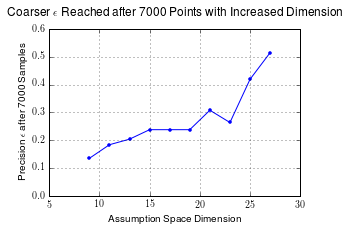

In [7]:
dimensions = np.array(sig_lengths)*net.input_dim + net.state_dim

learning = a_miner.learningrate
num_points = int(total_points[-1])

fig1, ax1 = plt.subplots()
line1 = ax1.plot(dimensions, precision, '.-')
ax1.set_label('Precision')
plt.rc('text', usetex=True)
ax1.set_title(r'Coarser ${\Large \epsilon}$ Reached after %s Points with Increased Dimension' % (num_samples), y = 1.05)
ax1.set_xlabel("Assumption Space Dimension")
ax1.set_ylim([0,.6])
ax1.set_ylabel(r'Precision ${\Large \epsilon}$ after %s Samples' % (num_samples))
ax1.grid()
fig1.set_size_inches(4.5, 3)

plt.show()

save_fig = False
if save_fig:
    fig1.savefig('fig_epsilon_reached_%s.pdf' % (num_points), bbox_inches='tight')